In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *
from utils.plot_utils import *

warnings.filterwarnings('ignore')

## Load geometric information

In [2]:
from scipy.io import loadmat

with h5py.File('Public/raw_dynamics_fitting.h5', 'r') as h5f:
    ap = h5f['ensemble/links/m_ij/AP_coordinates'][0, :][()]
    dv = h5f['ensemble/links/m_ij/DV_coordinates'][:, 0][()]
    dAP = ap[1]-ap[0]
    dDV = dv[1]-dv[0]
    YX = np.stack(np.meshgrid(dv, ap, indexing='ij'), axis=-1)

geo_dir = '../flydrive.synology.me/Public/dynamic_atlas/embryo_geometry'
geometry = loadmat(os.path.join(geo_dir, 'embryo_rectPIVscale_fundamentalForms.mat'), simplify_cells=True)
#Convert to microns
X0g = geometry['X0'][0, :] * 0.2619 / 0.4
Y0g = geometry['Y0'][:, 0] * 0.2619 / 0.4
print('Metric Extent: %.3f %.3f %.3f %.3f' % (
    X0g.min(), X0g.max(), Y0g.min(), Y0g.max()))
print('Data Extent: %.3f %.3f %.3f %.3f' % (
    ap.min(), ap.max(), dv.min(), dv.max()))

Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
print('Loaded Christoffel symbols from Public')

Metric Extent: 4.911 446.867 4.911 525.437
Data Extent: 3.230 455.701 3.227 536.891
Loaded Christoffel symbols from Public


## Build a Stokes translation model

In [3]:
from utils.decomposition_utils import *
from utils.translation_utils import *
from utils.dataset import *

transform=Reshape2DField()

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True)
vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True)

100%|██████████| 6/6 [00:00<00:00, 295.11it/s]


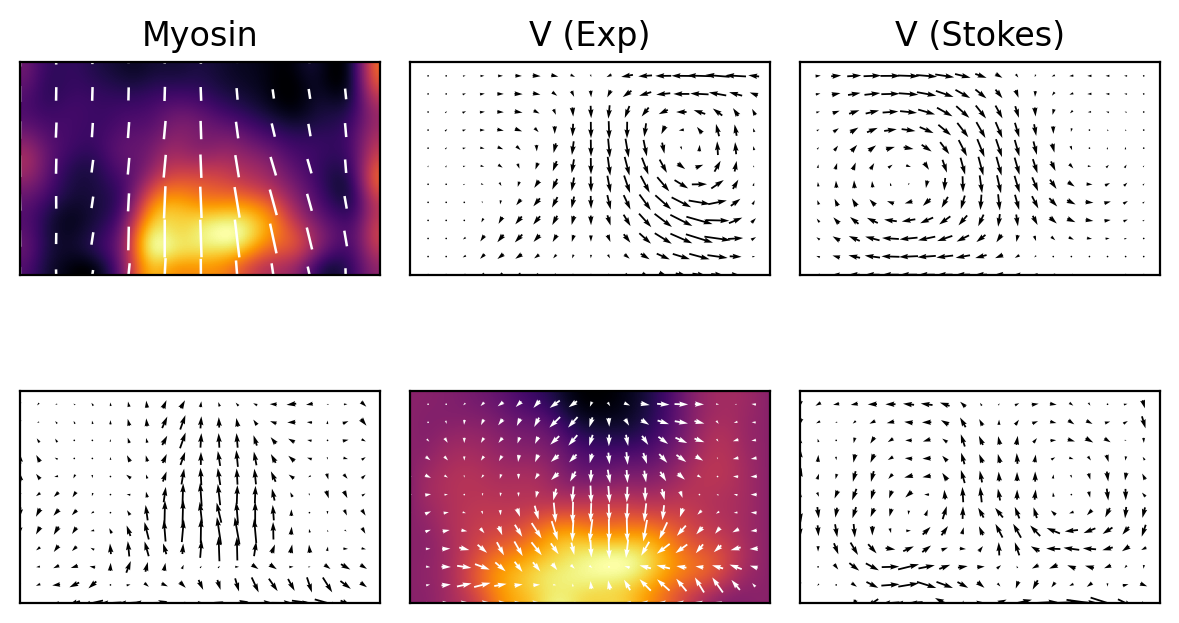

In [4]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from utils.decomposition_utils import LeftRightSymmetrize
from utils.plot_utils import *

from skimage.transform import downscale_local_mean
from scipy import sparse

class FlowSolver(object):
    def __init__(self, YY=dv, XX=ap, sigma=3, mu=1):
        super(FlowSolver, self).__init__()        
        
        self.nDV = YY.shape[0]
        self.nAP = XX.shape[0]

        self.dAP = XX[1] - XX[0]
        self.dDV = YY[1] - YY[0]
        self.sigma = sigma
        
        self.Gijk = np.load('Public/christoffel_symbols.npy', mmap_mode='r')
        
        #Build poisson matrix
        I_x = sparse.eye(self.nAP)
        I_y = sparse.eye(self.nDV)
        
        D2_x = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nAP, self.nAP))
        D2_y = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(self.nDV, self.nDV))
        
        #Dirichlet BCs in AP direction
        D2_x = sparse.lil_matrix(D2_x)
        D2_x[0, [0, 1]] = [1, 0]
        D2_x[-1, [-2, -1]] = [0, 1]
        D2_x = sparse.csr_matrix(D2_x)
        
        #periodic BCs in DV direction
        D2_y = sparse.lil_matrix(D2_y)
        D2_y[0, [-1, 0, 1]] = [1, -2, 1]
        D2_y[-1, [-2, -1, 0]] = [1, -2, 1]
        D2_y = sparse.csr_matrix(D2_y)
        
        D2_x = sparse.kron(I_y, D2_x) / self.dAP**2
        D2_y = sparse.kron(D2_y, I_x) / self.dDV**2
        
        self.A = D2_x + D2_y
        self.mu = mu
                
    def boundary_AP(self, f, ap=5):
        f[..., :ap] = 0
        f[..., -2*ap:] = 0
        return f
    
    def gradient(self, x):
        dY_x = gaussian_filter1d(x, axis=-2, sigma=self.sigma, order=1, mode='wrap') / self.dDV
        dX_x = gaussian_filter1d(x, axis=-1, sigma=self.sigma, order=1, mode='nearest') / self.dAP
        return np.stack([
            dY_x,
            dX_x,
        ], axis=-1)
    
    def covariant_gradient(self, x0):
        grad_x = self.gradient(x0)
        if len(x0.shape) == 3: #Vector
            grad_x += np.einsum('yxijk,kyx->iyxj', self.Gijk, x0)
        elif len(x0.shape) == 4: #Tensor
            grad_x += np.einsum('yxikl,ljyx->ijyxk', self.Gijk, x0) + \
                      np.einsum('yxjkl,ilyx->ijyxk', self.Gijk, x0)
        return grad_x
        
    def get_velocity(self, t, y, mask=None):
        #Get myosin and source
        m = y.reshape([2, 2, self.nDV, self.nAP])
        dev_m = m - 0.5 * np.einsum('kkyx,ij->ijyx', m, np.eye(2))

        #Gradients
        div_m = np.einsum('ijyxj->iyx', self.gradient(m))
        d2_m = np.einsum('iyxi->yx', self.gradient(div_m))
        
        # Mask poles
        d2_m = self.boundary_AP(d2_m)
                
        p = sparse.linalg.spsolve(self.A, d2_m.flatten())
        
        p = p.reshape([self.nDV, self.nAP])
        d1_p = self.gradient(p).transpose(2, 0, 1)
        
        rhs = -div_m + d1_p
        rhs = self.boundary_AP(rhs) / self.mu
        
        if mask is not None:
            rhs[:, ~mask] = 0
        
        v_y = sparse.linalg.spsolve(self.A, rhs[0].flatten())
        v_x = sparse.linalg.spsolve(self.A, rhs[1].flatten())
        
        v = np.stack([v_y, v_x]).reshape([2, self.nDV, self.nAP])
                        
        return v, p, div_m, dev_m

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = pd.read_csv(os.path.join(path, 'dynamic_index.csv'))
of = pd.read_csv(os.path.join(path, 'morphodynamic_offsets.csv'), index_col='embryoID')

from scipy.interpolate import interp1d
alpha = np.load('Public/Masks/Dynamic_PMG_CF_mask.npy')
talph = np.load('Public/Masks/Dynamic_PMG_CF_time.npy')
    
eId = df.embryoID.unique()[3]
t = 25
t = 15
t = 35
#t = 25

m0 = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')[t]
v0 = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')[t]
t = df.loc[df.embryoID == eId, 'eIdx'].values[t] - of.loc[eId, 'offset']
mask = interp1d(talph, alpha, axis=0, fill_value='extrapolate')(t).astype(bool)

v0 = LeftRightSymmetrize().fit_transform(v0[None])[0]
m0 = m0.reshape([4, 236, 200]).copy()
m0 = LeftRightSymmetrize().fit_transform(m0[None])[0]
m0 = m0.reshape([2, 2, 236, 200])
mask[:, 40:100] = 1

model = FlowSolver(mu=10)
v, p, div_m, dev_m = model.get_velocity(0, m0)

fig, ax = plt.subplots(2, 3, dpi=200)
alpha = mask.astype(float)
alpha[~mask] = 0.5
plot_tensor2D(ax[0, 0], dev_m)
plot_vector2D(ax[0, 1], v0)
plot_vector2D(ax[1, 0], -div_m)
color_2D(ax[1, 1], p)
plot_vector2D(ax[0, 2], v)
plot_vector2D(ax[1, 1], model.gradient(p).transpose([2, 0, 1]), color='white')
plot_vector2D(ax[1, 2], model.gradient(p).transpose([2, 0, 1]) - div_m)

ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('V (Exp)')
ax[0, 2].set_title('V (Stokes)')

#for a in ax.flatten():
#    a.set_ylim([dv_min, dv_max])
#    a.set_xlim([ap_min, ap_max])

plt.tight_layout()

## Translate to 3D and back to 2D

In [5]:
from fenics import Function, dof_to_vertex_map, Mesh
from scipy.io import loadmat
from scipy import sparse
from sklearn.neighbors import KDTree

import numpy as np
import os

from fenics import Mesh
from scipy.interpolate import RectBivariateSpline, griddata

from utils.plot_utils import *

'''
3D plotting
'''
def format_ax(ax, mesh=mesh, a0=-90, a1=-90, title=''):
    verts = mesh.coordinates()
    ax.view_init(a0, a1)
    ax.set_box_aspect((
        np.ptp(verts[:, 2]),
        np.ptp(verts[:, 0]),
        np.ptp(verts[:, 1])))  # aspect ratio is 1:1:1 in data space#set_axes_equal(ax)
    axmin = np.min(verts, axis=0)
    axmax = np.max(verts, axis=0)
    ax.set(
        xlim=[axmin[2], axmax[2]],
        ylim=[axmin[0], axmax[0]],
        zlim=[axmin[1], axmax[1]],
    )
    ax.dist = 10.
    ax.patch.set_alpha(0.)
    ax.axis('off')
    ax.text2D(0.5, 0.7, title,
          transform=ax.transAxes,
          va='bottom', ha='center')


def color_mesh(ax, f, norm=None, cmap='magma', linewidth=0., title='', offset=np.zeros(3)):
    verts = mesh.coordinates().copy()
    verts += offset
    faces = mesh.cells()
    p3dc = ax.plot_trisurf(
        verts[:, 2], verts[:, 0], verts[:, 1],
        edgecolor='lightgray', linewidth=linewidth, triangles=faces)
    f_faces = np.zeros(faces.shape[0])
    for fid, face in enumerate(faces):
        f_faces[fid] = np.mean(f[face])

    if norm is None:
        norm = Normalize()
    colors = get_cmap(cmap)(norm(f_faces))
    p3dc.set_fc(colors)
    format_ax(ax, title=title)

def plot_vector3D(ax, f, title='', normalize=True):
    verts = mesh.coordinates()
    color_mesh(ax, np.zeros(verts.shape[0]), title=title, cmap='Greys')
    skip = 3

    mask = verts[:, 1] < 0
    fv = f[:, mask][:, ::skip]
    rv = verts[mask][::skip, :].T

    qwargs = dict(pivot='middle', color='red', length=1e2, normalize=normalize, linewidth=.5)
    ax.quiver(rv[2], rv[0], rv[1],
              fv[2], fv[0], fv[1],
              **qwargs)

def plot_tensor3D(ax, f0, skip=3, title='', norm=None, vmax=None):
    verts = mesh.coordinates()
    f = f0.copy().reshape([3, 3, -1]).transpose(2, 0, 1)
    fnorm = np.linalg.norm(f, axis=(1, 2))
    fnorm = np.einsum('vii->v', f)
    if norm is None:
        norm = Normalize(vmin=0, vmax=vmax*np.std(fnorm)) if vmax else None
    color_mesh(ax, fnorm, norm=norm, title=title)
    el, ev = np.linalg.eig(f)

    order = np.argmax(el, axis=-1) #Find position of largest eigenvector
    ev = np.array([ev[i, :, ei] for i, ei in enumerate(order)])
    qwargs = dict(pivot='middle', color='white', length=100, normalize=True, arrow_length_ratio=0.5, linewidth=0.5)
    mask = verts[:, 1] < 0
    ev = ev[mask][::skip, :].T
    rm = verts[mask][::skip, :].T
    ax.quiver(rm[2], rm[0], rm[1],
              ev[2], ev[0], ev[1],
              **qwargs)

geo_dir = '/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas/embryo_geometry/'
mesh = Mesh(os.path.join(geo_dir, 'embryo_coarse_noll.xml'))
tangent_space_data = loadmat(os.path.join(geo_dir, 'embryo_3D_geometry.mat'))


z_emb = tangent_space_data['z'][:, 0]
phi_emb = tangent_space_data['ph'][:, 0]

e1 = tangent_space_data['e2'] #We use y-first convention
e2 = tangent_space_data['e1'] #We use y-first convention
Nv = e1.shape[0]
E11, E12, E21, E22 = [], [], [], []
E1, E2 = [], []
for i in range(3):
    E1.append(sparse.spdiags(e1[:, i], 0, Nv, Nv))
    E2.append(sparse.spdiags(e2[:, i], 0, Nv, Nv))
    for j in range(3):
        E11.append(sparse.spdiags(e1[:, i]*e1[:, j], 0, Nv, Nv))
        E12.append(sparse.spdiags(e1[:, i]*e2[:, j], 0, Nv, Nv))
        E21.append(sparse.spdiags(e2[:, i]*e1[:, j], 0, Nv, Nv))
        E22.append(sparse.spdiags(e2[:, i]*e2[:, j], 0, Nv, Nv))

N_vector = sparse.vstack([sparse.hstack(E1), sparse.hstack(E2)])
N_tensor = sparse.vstack([sparse.hstack(E11), sparse.hstack(E12), sparse.hstack(E21), sparse.hstack(E22)])

def convert_bilinear_dof(a, v2d, N=None):
    a = np.array(a.array())
    a = a[:, v2d]
    a = a[v2d, :]
    a = sparse.csr_matrix(a)
    if N is not None:
        a = N.dot(a.dot(N.T)) #Push A to tangent space
    return a

def convert_linear_dof(l, v2d, N=None):
    l = np.array(l)
    l = l[v2d].T
    l = sparse.csr_matrix(l)
    if N is not None:
        l = N.dot(l.reshape([-1, 1])) #Push L to tangent space
    return l

def pull_vector_from_tangent_space(M, e1=e1, e2=e2):
    Nv = e1.shape[0]
    Mi = M.flatten()
    return np.einsum('Vi,V->iV', e1, Mi[:Nv]) + \
           np.einsum('Vi,V->iV', e2, Mi[Nv:])

def pull_tensor_from_tangent_space(M, e1=e1, e2=e2):
    Nv = e1.shape[0]
    Mi = M.flatten()
    return np.einsum('Vi,V,Vj->ijV', e1, Mi[:Nv], e1) + \
           np.einsum('Vi,V,Vj->ijV', e1, Mi[Nv:2*Nv], e2) + \
           np.einsum('Vi,V,Vj->ijV', e2, Mi[2*Nv:3*Nv], e1) + \
           np.einsum('Vi,V,Vj->ijV', e2, Mi[3*Nv:], e2)

def interpolate_mesh_vertices(f0):
    header_shape = f0.shape[:-2]
    f1 = f0.reshape([-1, *f0.shape[-2:]])
    
    #Interpolate to vertex points
    Z_AP = np.linspace(z_emb.min(), z_emb.max(), f0.shape[-1])
    Phi_DV = np.linspace(phi_emb.min(), phi_emb.max(), f0.shape[-2]) #This goes the opposite direction of Y

    f = []
    for i in range(f1.shape[0]):
        fi = RectBivariateSpline(Phi_DV, Z_AP, f1[i])(phi_emb, z_emb, grid=False)
        f.append(fi)
    f = np.stack(f).reshape([*header_shape, -1])
        
    #Account for switch of DV direction
    if len(f.shape) == 2: #It's a vector
        f[0] *= -1 #Since we inverted phi
        
    elif len(f.shape) == 3: #It's a tensor
        f[1, 0] *= -1
        f[0, 1] *= -1

    return f

def interpolate_vertex_to_grid(f0, nDV=236, nAP=200):
    f1 = f0.reshape([-1, Nv])
    
    #Interpolate to vertex points
    Z_AP = np.linspace(z_emb.min(), z_emb.max(), nAP)
    Phi_DV = np.linspace(phi_emb.min(), phi_emb.max(), nDV) #This goes the opposite direction of Y

    f = []
    for i in range(f1.shape[0]):
        fi = griddata(
            (phi_emb, z_emb), f1[i], 
            (Phi_DV[:, None], Z_AP[None, :])
        )
        f.append(fi)
    f = np.stack(f)
    
    if f.shape[0] == 2: #It's a vector
        f[0] *= -1
    elif f.shape[0] == 4: #It's a tensor
        f[1:3] *= -1
    
    return f

def push_to_embryo_surface(f0):
    f = interpolate_mesh_vertices(f0)

    #Now convert using embryo surface basis vectors
    if len(f.shape) == 2: #Transforms like a vector
        return pull_vector_from_tangent_space(f.flatten())
    elif len(f.shape) == 3: #Transforms like a tensor
        return pull_tensor_from_tangent_space(f.flatten())
    else:
        return f

-10 9.35918009759007e-12
(1797,) float64


ValueError: x and y arrays must be equal in length along interpolation axis.

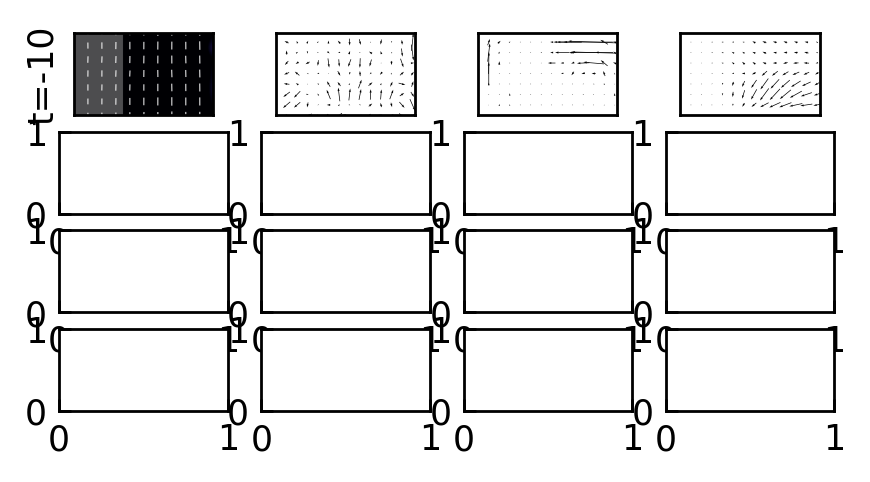

In [10]:
#Solve system exactly
from fenics import interpolate, project
from fenics import inner, grad, dot, div, dx
from fenics import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from fenics import FunctionSpace, VectorElement, TensorElement, MixedElement
from fenics import Mesh, Expression, Constant

from fenics import assemble_system, vertex_to_dof_map
from scipy import sparse
from scipy.sparse.linalg import spsolve


v = VectorElement('CG', mesh.ufl_cell(), 1)
t = TensorElement('CG', mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, v)
T = FunctionSpace(mesh, t)

def solve_for_flow(m0, time=0):
    eta = (1 + np.tanh(time-5)) * 50
    print(time, eta)
    v2d = vertex_to_dof_map(V).reshape([-1, 3]).T.flatten()

    u = TrialFunction(V)
    v = TestFunction(V)
    A = -inner(grad(u), grad(v)) * dx(domain=mesh) + \
        -eta * div(u) * div(v) * dx(domain=mesh)
    B = inner(u, v) * dx(domain=mesh)
    L = dot(Constant((0., 0., 0.)), v) * dx(domain=mesh)

    A = convert_bilinear_dof(assemble_system(A, L)[0], v2d, N_vector)
    B = convert_bilinear_dof(assemble_system(B, L)[0], v2d, N_vector)

    div_m = np.einsum('ijyxj->iyx', model.gradient(m0))

    m_2D = interpolate_mesh_vertices(mask)
    print(m_2D.shape, m_2D.dtype)
    f_2D = interpolate_mesh_vertices(-div_m)
    f_2D[:, m_2D < 1] = 0
    L = B.dot(f_2D.flatten())

    v1 = spsolve(A, L)
    v1_3D = pull_vector_from_tangent_space(v1)
    v1 = interpolate_vertex_to_grid(v1)
    return v1, div_m

path = 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/'
df = pd.read_csv(os.path.join(path, 'dynamic_index.csv'))
of = pd.read_csv(os.path.join(path, 'morphodynamic_offsets.csv'), index_col='embryoID')

from scipy.interpolate import interp1d
alpha = np.load('Public/Masks/Dynamic_PMG_CF_mask.npy')
talph = np.load('Public/Masks/Dynamic_PMG_CF_time.npy')
    
eId = df.embryoID.unique()[2]
m_full = np.load(os.path.join(path, str(eId), 'tensor2D.npy'), mmap_mode='r')
v_full = np.load(os.path.join(path, str(eId), 'velocity2D.npy'), mmap_mode='r')
t_full = df.loc[df.embryoID == eId, 'eIdx'].values - of.loc[eId, 'offset']
masker = interp1d(talpha, alpha, axis=0, fill_value='extrapolate')

mnorm = np.linalg.norm(m_full, axis=(1, 2))
mmin = np.median(mnorm)
mmax = mmin + 4 * mnorm.std()

fig, ax = plt.subplots(4, 4, dpi=250, figsize=(4, 2))

for i, t in enumerate([3, 13, 23, 33]):
    v0 = LeftRightSymmetrize().fit_transform(v_full[t:t+1])[0]
    m0 = m_full[t].reshape([1, 4, 236, 200])
    m0 = LeftRightSymmetrize().fit_transform(m0)[0].reshape([2, 2, 236, 200])
    time = t_full[t]
    mask = interp1d(talph, alpha, axis=0, fill_value='extrapolate')(time).astype(bool)

    v1, div_m = solve_for_flow(m0, time)


    alpha = mask.astype(float)
    alpha[alpha == 0] = 0.7
    plot_tensor2D(ax[i, 0], m0, vmin=mmin, vmax=mmax, alpha=alpha)
    plot_vector2D(ax[i, 1], -div_m, skip=15)
    plot_vector2D(ax[i, 2], v0, skip=15)
    plot_vector2D(ax[i, 3], v1, skip=15)
    ax[i, 0].set_ylabel('t=%d' % time)
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('Div (Myosin)')
ax[0, 2].set_title('V (Exp)')
ax[0, 3].set_title('V (Stokes)')

'''
fig, ax = plt.subplots(1, 4, dpi=150, subplot_kw={'projection': '3d'})
plot_tensor3D(ax[0], push_to_embryo_surface(m0[..., :-20]))
plot_vector3D(ax[1], push_to_embryo_surface(-div_m))
plot_vector3D(ax[2], push_to_embryo_surface(v0))
plot_vector3D(ax[3], v1_3D)
''';